# Setup and data preparation

In [1]:
import pandas as pd

churnData = pd.read_csv("Customer-Churn.csv")

churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [2]:
churnData.shape

(7043, 16)

In [3]:
print(churnData.dtypes)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [4]:
churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"], errors="coerce")
print(churnData["TotalCharges"].dtypes)

float64


In [5]:
churnData.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
# Replace nulls in 'TotalCharges' with the median (using the median since TotalCharges follows a skewed distribution)
churnData['TotalCharges'] = churnData['TotalCharges'].fillna(churnData['TotalCharges'].median())

In [7]:
churnData.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Train-test split

from sklearn.model_selection import train_test_split

X = churnData[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y = churnData['Churn'].map({'Yes': 1, 'No': 0})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Scaling
# Note: doing it after train-test split, to avoid data leakage

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Basic logistic regression (without managing imbalance)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fit logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict and check accuracy
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8070


In [11]:
#
# Result: we get an accuracy of 0.8
#

Accuracy: 0.8070
Recall: 0.4772
Precision: 0.6980


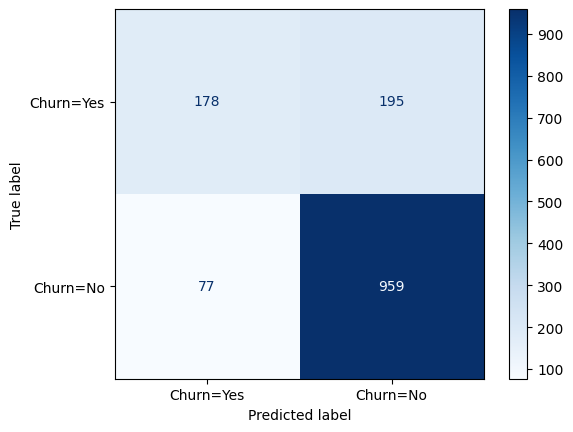

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score


# confussion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # [Positive, Negative]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn=Yes', 'Churn=No'])
disp.plot(cmap="Blues")


# accuracy, recall, precission
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')



# Check imbalance

In [13]:
churnData["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [14]:
print(churnData['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [15]:
#
# Analysis: there is a clear class imbalance in the dataset.
#

# Upsampling

In [16]:
from sklearn.utils import resample

train = pd.concat([X_train, y_train], axis=1)

# separate majority/minority classes
df_majority = train[train.Churn == 0]
df_minority = train[train.Churn == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target again
X_train_upsampled = train_upsampled.drop('Churn', axis=1)
y_train_upsampled = train_upsampled['Churn']

In [17]:
train_upsampled["Churn"].value_counts()

Churn
0    4138
1    4138
Name: count, dtype: int64

In [18]:
# Scale again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Perform logistic regression with the upsampled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train_upsampled)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after upsampling: {accuracy:.4f}')

Accuracy after upsampling: 0.7452


In [19]:
#
# Analysis: we can see that after doing upsampling, we get lower accuracy.
# Lower accuracy can happen because balancing forces the model to better recognize the minority class
#

# Let's check the confussion matrix!

Accuracy: 0.7452
Recall: 0.7748
Precision: 0.5124


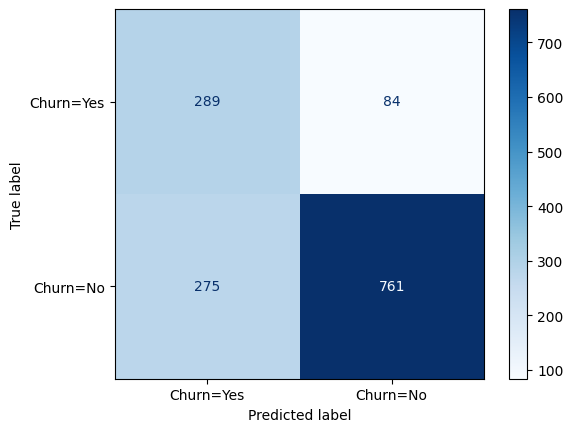

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score


# confussion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # [Positive, Negative]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn=Yes', 'Churn=No'])
disp.plot(cmap="Blues")


# accuracy, recall, precission
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')


In [21]:
#
# Analysis: we can see that after doing upsampling, we get lower accuracy.
# However, we get way better recall!!

# Downsampling

In [22]:
from sklearn.utils import resample

train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = train[train.Churn == 0]
df_minority = train[train.Churn == 1]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

# Combine minority class with downsampled majority class
train_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
train_downsampled = train_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target again
X_train_downsampled = train_downsampled.drop('Churn', axis=1)
y_train_downsampled = train_downsampled['Churn']


In [25]:
train_downsampled["Churn"].value_counts()

Churn
0    1496
1    1496
Name: count, dtype: int64

In [26]:
# Scale again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_downsampled)
X_test_scaled = scaler.transform(X_test)

# Perform logistic regression with the downsampled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train_downsampled)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after downsampling: {accuracy:.4f}')

Accuracy after downsampling: 0.7445


Accuracy: 0.7445
Recall: 0.7668
Precision: 0.5116


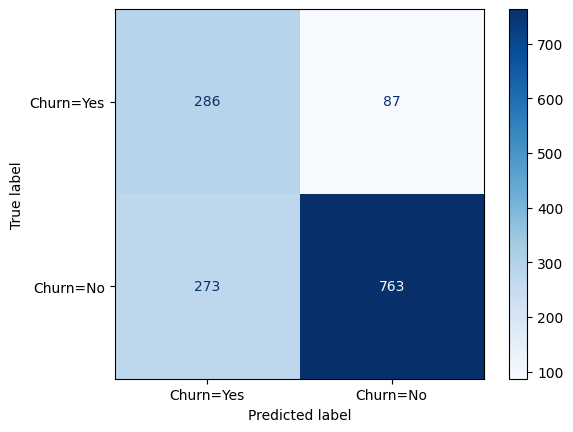

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score


# confussion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # [Positive, Negative]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn=Yes', 'Churn=No'])
disp.plot(cmap="Blues")


# accuracy, recall, precission
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')


In [ ]:
#
# Analysis: 
# - we can see that after applying downsampling we also improve recall 
# - in this case, upsampling and downsampling, both provide a similar confusion matrix.
# - upsampling would be better because it keeps all original data from the majority class and avoids losing information. 
# - a hybrid approach, combining both upsampling and downsampling, can also be a good option.
#